In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings

# Suppress only the RuntimeWarning for overflow
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
Data = pd.read_csv("Datasets/banknote/data_banknote_authentication.csv")
Data = Data.to_numpy()

In [3]:
m, n = Data.shape
n0 = n - 1

In [4]:
np.random.seed(14)

randseq = np.random.permutation(m)
Data = Data[randseq[0:m], 0:n]

In [5]:
trainval = math.floor(m*0.8)
testval = m - trainval

In [6]:
NumberOfHorClients = 10

FeaturesVer = 2

if FeaturesVer > 0 and FeaturesVer < n0:

    Data_reg = Data[0:trainval, 0:FeaturesVer]

    numperuser = int(np.round(trainval/NumberOfHorClients))

    samples = np.zeros(NumberOfHorClients)

    for i in range(np.size(samples) - 1):
        SplitData_reg = Data[(i*numperuser):((i+1)*numperuser), 0:FeaturesVer]
        pd.DataFrame(SplitData_reg).to_csv("data_split/data_split_ver_"+str(i+1)+ ".csv", header=False, index=False)

        SplitData_hos = Data[(i*numperuser):((i+1)*numperuser), FeaturesVer:n]
        pd.DataFrame(SplitData_hos).to_csv("data_split/data_split_hor_"+str(i+1)+ ".csv", header=False, index=False)
        
    SplitData_reg = Data[(NumberOfHorClients-1)*numperuser:trainval, 0:FeaturesVer]
    pd.DataFrame(SplitData_reg).to_csv("data_split/data_split_ver_"+str(NumberOfHorClients)+ ".csv", header=False, index=False)

    SplitData_hos = Data[(NumberOfHorClients-1)*numperuser:trainval, FeaturesVer:n]
    pd.DataFrame(SplitData_hos).to_csv("data_split/data_split_hor_"+str(NumberOfHorClients)+ ".csv", header=False, index=False)

else:
    raise Exception("Number of features for registry should be greater than 0 and less than "+str(n0))

In [7]:
X_test = Data[trainval:m+1, 0:n0].T
y_test = Data[trainval:m+1, n0].reshape(1, m-trainval)

In [8]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [9]:
L = 4
nx = np.array([n0, 5, 5, 1])

In [10]:
# Server initializes the global model

W1_hor = np.random.randn(nx[1], 2) # W1 for the horizontal clients

b1 = np.random.randn(nx[1],1)

W2 = np.random.randn(nx[2],nx[1])
b2 = np.random.randn(nx[2],1)

W3 = np.random.randn(nx[3],nx[2])
b3 = np.random.randn(nx[3],1)

# W1 for the vertical client
W1_ver = np.random.randn(nx[1], 2) 

# Saving the global model in csv files

pd.DataFrame(W1_hor).to_csv("avg_parameters/W1_hor_avg.csv", header=False, index=False)
pd.DataFrame(W1_ver).to_csv("avg_parameters/W1_ver_avg.csv", header=False, index=False)

pd.DataFrame(W2).to_csv("avg_parameters/W2_avg.csv", header=False, index=False)
pd.DataFrame(W3).to_csv("avg_parameters/W3_avg.csv", header=False, index=False)

pd.DataFrame(b1).to_csv("avg_parameters/b1_avg.csv", header=False, index=False)
pd.DataFrame(b2).to_csv("avg_parameters/b2_avg.csv", header=False, index=False)
pd.DataFrame(b3).to_csv("avg_parameters/b3_avg.csv", header=False, index=False)

In [11]:
learning_rate = 0.05
iterations = 10
rounds = 100

Avg_Loss = np.zeros((rounds,1))
Accuracy = np.zeros((rounds,1))

for r in range(rounds):

    for client in range(NumberOfHorClients): 
        
        Data_X = pd.read_csv("data_split/data_split_hor_"+str(client+1)+".csv", header=None)
        Data_X = Data_X.to_numpy()

        m_X, n_X = Data_X.shape
        n0 = n_X - 1

        X_train = Data_X[:, 0:n0].T
        y_train = Data_X[:, n0].reshape(1, m_X)

        # Reading vertical data (only those sample points which correspond respective horizontal client)
        X_ver = pd.read_csv("data_split/data_split_ver_"+str(client+1)+".csv", header=None)
        X_ver = X_ver.to_numpy().T

        # Each horizontal client uses the global model received from 
        # the server in the first iteration

        W1_hor = pd.read_csv("avg_parameters/W1_hor_avg.csv", header=None)
        W1_hor = W1_hor.to_numpy()

        W2 = pd.read_csv("avg_parameters/W2_avg.csv", header=None)
        W2 = W2.to_numpy()

        W3 = pd.read_csv("avg_parameters/W3_avg.csv", header=None)
        W3 = W3.to_numpy()

        b1 = pd.read_csv("avg_parameters/b1_avg.csv", header=None)
        b1 = b1.to_numpy()

        b2 = pd.read_csv("avg_parameters/b2_avg.csv", header=None)
        b2 = b2.to_numpy()

        b3 = pd.read_csv("avg_parameters/b3_avg.csv", header=None)
        b3 = b3.to_numpy()

        # For vertical client

        W1_ver = pd.read_csv("avg_parameters/W1_ver_avg.csv", header=None)
        W1_ver = W1_ver.to_numpy()

        J = np.zeros((iterations,1))

        for i in range(iterations):

            Z1_hor = np.dot(W1_hor, X_train) # Done at horizontal client
            Z1_ver = np.dot(W1_ver, X_ver)   # Done at vertical client

            # Vertical client will send Z1_ver to the respective horizontal client
            Z1_t = Z1_hor + Z1_ver      # Done at horizontal client

            # Forward propagation
            Z1 = Z1_t + b1
            A1 = sigmoid(Z1)

            Z2 = np.dot(W2, A1) + b2
            A2 = sigmoid(Z2)

            Z3 = np.dot(W3, A2) + b3
            A3 = sigmoid(Z3)

            # J[i] = (-1/m_X)*np.sum(y_train*np.log(A3) + (1-y_train)*np.log(1-A3))
            
            # Backward propagation
            dZ3 = A3-y_train
            dW3 = (1/m_X)*np.dot(dZ3, A2.T)
            db3 = (1/m_X)*np.sum(dZ3, axis = 1, keepdims = True)

            dA2 = A2*(1-A2)
            dZ2 = np.dot(W3.T, dZ3)*dA2
            dW2 = (1/m_X)*np.dot(dZ2, A1.T)
            db2 = (1/m_X)*np.sum(dZ2, axis = 1, keepdims = True)

            dA1 = A1*(1-A1)
            dZ1 = np.dot(W2.T, dZ2)*dA1
            db1 = (1/m_X)*np.sum(dZ1, axis = 1, keepdims = True)

            dW1_hor = (1/m_X)*np.dot(dZ1, X_train.T)

            W1_hor = W1_hor - learning_rate*dW1_hor
            b1 = b1 - learning_rate*db1

            W2 = W2 - learning_rate*dW2
            b2 = b2 - learning_rate*db2

            W3 = W3 - learning_rate*dW3
            b3 = b3 - learning_rate*db3

            # Horizontal client will send dZ1 to the vertical client
            dW1_ver = (1/m_X)*np.dot(dZ1, X_ver.T)   # Done at vertical client
            W1_ver = W1_ver - learning_rate*dW1_ver  # Done at vertical client

        # Each horizontal client sends the local models to
        # the server
        pd.DataFrame(W1_hor*m_X).to_csv("ind_parameters/W1_hor_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W2*m_X).to_csv("ind_parameters/W2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W3*m_X).to_csv("ind_parameters/W3_"+str(client+1)+".csv", header=False, index=False)

        pd.DataFrame(b1*m_X).to_csv("ind_parameters/b1_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b2*m_X).to_csv("ind_parameters/b2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b3*m_X).to_csv("ind_parameters/b3_"+str(client+1)+".csv", header=False, index=False)

        # Vertical client can save this on its own
        pd.DataFrame(W1_ver*m_X).to_csv("ind_parameters/W1_ver_"+str(client+1)+".csv", header=False, index=False)

    # The server aggregate/average the local models

    W1_hor = np.zeros([nx[1],2]) 
    W1_ver = np.zeros([nx[1],2]) 
    b1 = np.zeros([nx[1],1])

    W2 = np.zeros([nx[2],nx[1]]) 
    b2 = np.zeros([nx[2],1])

    W3 = np.zeros([nx[3],nx[2]])
    b3 = np.zeros([nx[3],1])

    for client in range(NumberOfHorClients):
        # At vertical client
        W1_ver = W1_ver + pd.read_csv("ind_parameters/W1_ver_"+str(client+1)+".csv", header=None)

        # At Server
        W1_hor = W1_hor + pd.read_csv("ind_parameters/W1_hor_"+str(client+1)+".csv", header=None)
        W2 = W2 + pd.read_csv("ind_parameters/W2_"+str(client+1)+".csv", header=None)
        W3 = W3 + pd.read_csv("ind_parameters/W3_"+str(client+1)+".csv", header=None)

        b1 = b1 + pd.read_csv("ind_parameters/b1_"+str(client+1)+".csv", header=None)
        b2 = b2 + pd.read_csv("ind_parameters/b2_"+str(client+1)+".csv", header=None)
        b3 = b3 + pd.read_csv("ind_parameters/b3_"+str(client+1)+".csv", header=None)

    W1_hor = W1_hor.to_numpy()
    W1_ver = W1_ver.to_numpy()
    W2 = W2.to_numpy()
    W3 = W3.to_numpy()

    b1 = b1.to_numpy()
    b2 = b2.to_numpy()
    b3 = b3.to_numpy()

    W1_hor_avg = W1_hor/trainval
    W1_ver_avg = W1_ver/trainval
    W2_avg = W2/trainval
    W3_avg = W3/trainval

    b1_avg = b1/trainval
    b2_avg = b2/trainval
    b3_avg = b3/trainval

    pd.DataFrame(W1_hor).to_csv("avg_parameters/W1_hor_avg.csv", header=False, index=False)
    pd.DataFrame(W1_ver).to_csv("avg_parameters/W1_ver_avg.csv", header=False, index=False)
    pd.DataFrame(W2_avg).to_csv("avg_parameters/W2_avg.csv", header=False, index=False)
    pd.DataFrame(W3_avg).to_csv("avg_parameters/W3_avg.csv", header=False, index=False)

    pd.DataFrame(b1_avg).to_csv("avg_parameters/b1_avg.csv", header=False, index=False)
    pd.DataFrame(b2_avg).to_csv("avg_parameters/b2_avg.csv", header=False, index=False)
    pd.DataFrame(b3_avg).to_csv("avg_parameters/b3_avg.csv", header=False, index=False)

    # Evaluation of the global model on
    # the testing dataset
    W1 = np.concatenate((W1_ver_avg, W1_hor_avg), axis=1)

    Z1 = np.dot(W1, X_test) + b1_avg
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2_avg, A1) + b2_avg
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3_avg, A2) + b3_avg
    A3 = sigmoid(Z3)

    Avg_Loss[r] = (-1/m)*np.sum(y_test*np.log(A3) + (1-y_test)*np.log(1-A3))

    y_pred = A3 > 0.5
    Accuracy[r] = 1 - np.sum(abs(y_pred - y_test))/testval

    print(f"Round: {r+1}, Loss: {Avg_Loss[r]}, Accuracy: {Accuracy[r]}")

Round: 1, Loss: [0.14311447], Accuracy: [0.59636364]
Round: 2, Loss: [0.13644384], Accuracy: [0.59636364]
Round: 3, Loss: [0.13322212], Accuracy: [0.59636364]
Round: 4, Loss: [0.13125367], Accuracy: [0.59636364]
Round: 5, Loss: [0.12977119], Accuracy: [0.65818182]
Round: 6, Loss: [0.1284506], Accuracy: [0.65818182]
Round: 7, Loss: [0.12717162], Accuracy: [0.67272727]
Round: 8, Loss: [0.12589846], Accuracy: [0.82181818]
Round: 9, Loss: [0.12462661], Accuracy: [0.84]
Round: 10, Loss: [0.12336105], Accuracy: [0.84]
Round: 11, Loss: [0.12210808], Accuracy: [0.84]
Round: 12, Loss: [0.12087279], Accuracy: [0.84]
Round: 13, Loss: [0.11965864], Accuracy: [0.86545455]
Round: 14, Loss: [0.11846764], Accuracy: [0.86909091]
Round: 15, Loss: [0.11730077], Accuracy: [0.85454545]
Round: 16, Loss: [0.11615829], Accuracy: [0.85454545]
Round: 17, Loss: [0.11504003], Accuracy: [0.85454545]
Round: 18, Loss: [0.11394555], Accuracy: [0.85454545]
Round: 19, Loss: [0.11287424], Accuracy: [0.85454545]
Round: 2

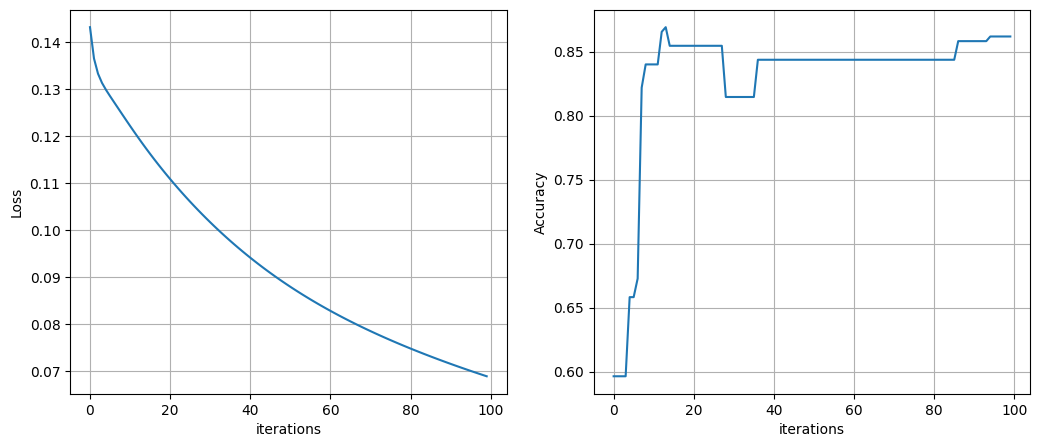

In [12]:
plt.subplot(1, 2, 1)
plt.plot(Avg_Loss)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(Accuracy)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Accuracy')

plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()